# Calculate harmonics of the baroclinic sea surface height data

In [12]:
# Use a dask client
from dask.distributed import Client, LocalCluster, worker, progress, wait
import dask
from dask import delayed
from dask_jobqueue import SLURMCluster

In [13]:
cluster = SLURMCluster()
client=Client(cluster)
cluster.scale(8)
client

/home/mrayson/group/mrayson/miniconda3/envs/soda/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


<Client: 'tcp://146.118.38.53:40319' processes=0 threads=0, memory=0 B>

In [14]:
#from soda.dataio.suntans.sunpy import Spatial
import xarray as xr
import dask
from netCDF4 import Dataset
import numpy as np
from glob import glob
from datetime import datetime
import re

from soda.dataio.suntans.sunxray import Sundask, Sunxray
from soda.utils.myproj import MyProj
from soda.utils.otherplot import axcolorbar
import soda.utils.harmonic_analysis as ha
from soda.utils.othertime import SecondsSince
from soda.dataio.suntans.suntans_ugrid import ugrid

import matplotlib.animation as animation
from IPython.display import HTML

from matplotlib import rcParams

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "14"
rcParams['axes.labelsize']='large'

import matplotlib.pyplot as plt

In [15]:
outpath = '../SCENARIOS/OUTPUT_NWS_2km_GLORYS_hex_2013_2014'
basefile = 'NWS_2km_GLORYS_hex_2013_2014_SSHBC'
infile = '{}/{}.nc.*'.format(outpath, basefile)
print(infile)

../SCENARIOS/OUTPUT_NWS_2km_GLORYS_hex_2013_2014/NWS_2km_GLORYS_hex_2013_2014_SSHBC.nc.*


In [17]:
sun = Sundask(infile)
sun._ds

Time dimension time
converting variable: xp
converting variable: yp


<xarray.Dataset>
Dimensions:  (Nc: 973, Ne: 3057, Nk: 1, Nkw: 2, Np: 454016, numsides: 8, time: 8772, two: 2)
Coordinates:
    xv       (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    yv       (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    xe       (Ne) float64 dask.array<chunksize=(3057,), meta=np.ndarray>
    ye       (Ne) float64 dask.array<chunksize=(3057,), meta=np.ndarray>
    Nk       (Nc) int32 dask.array<chunksize=(973,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
Dimensions without coordinates: Nc, Ne, Nkw, Np, numsides, two
Data variables:
    xp       (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yp       (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    lonv     (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    latv     (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    lonp     (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    latp     (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    cells    (Nc, numsides) int32 dask.array<chunksize=(973, 8), meta=np.ndarray>
    face     (Nc, numsides) int32 dask.array<chunksize=(973, 8), meta=np.ndarray>
    nfaces   (Nc) int32 dask.array<chunksize=(973,), meta=np.ndarray>
    edges    (Ne, two) int32 dask.array<chunksize=(3057, 2), meta=np.ndarray>
    neigh    (Nc, numsides) int32 dask.array<chunksize=(973, 8), meta=np.ndarray>
    grad     (Ne, two) int32 dask.array<chunksize=(3057, 2), meta=np.ndarray>
    mark     (Ne) int32 dask.array<chunksize=(3057,), meta=np.ndarray>
    normal   (Nc, numsides) int32 dask.array<chunksize=(973, 8), meta=np.ndarray>
    mnptr    (Nc) int32 dask.array<chunksize=(973,), meta=np.ndarray>
    eptr     (Ne) int32 dask.array<chunksize=(3057,), meta=np.ndarray>
    n1       (Ne) float64 dask.array<chunksize=(3057,), meta=np.ndarray>
    n2       (Ne) float64 dask.array<chunksize=(3057,), meta=np.ndarray>
    df       (Ne) float64 dask.array<chunksize=(3057,), meta=np.ndarray>
    dg       (Ne) float64 dask.array<chunksize=(3057,), meta=np.ndarray>
    def      (Nc, numsides) float64 dask.array<chunksize=(973, 8), meta=np.ndarray>
    Ac       (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    dv       (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    dz       (Nk) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    z_r      (Nk) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    z_w      (Nkw) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    Nke      (Ne) int32 dask.array<chunksize=(3057,), meta=np.ndarray>
    ssh_bc   (time, Nc) float64 dask.array<chunksize=(8772, 973), meta=np.ndarray>
Attributes:
    Description:  SUNTANS History file
    Author:       
    Created:      2020-07-09T07:53:56.076803

In [18]:
# Let's try lazy loading all of the data
ssh = sun.get_data('ssh_bc')
ssh

dask.array<concatenate, shape=(8772, 246720), dtype=float64, chunksize=(8772, 8939), chunktype=numpy.ndarray>

In [19]:
# Compute the variance along the time axis
ssh_var = ssh.var(axis=0)
ssh_var = ssh_var.compute()[...,sun.ghost]

(<Figure size 864x576 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x2b874a592ed0>)

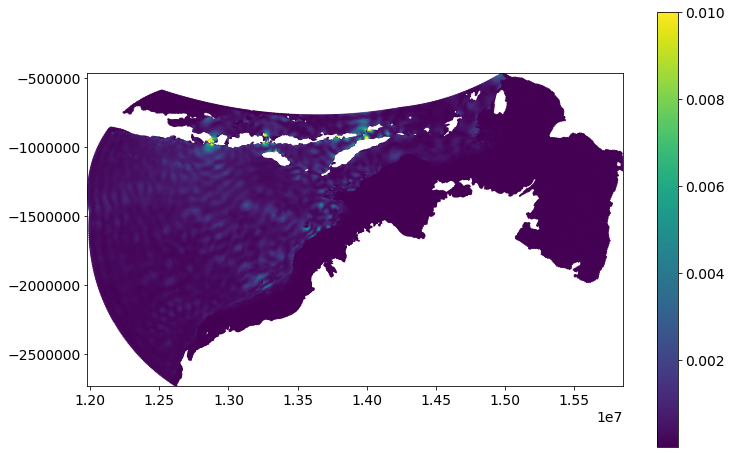

In [20]:
plt.figure(figsize=(12,8))
sun.plotcelldata(ssh_var, vmax=0.01)

In [21]:
def build_lhs_dask(t,frq):
    """
    Construct matrix A
    """
    nt=t.shape[0]
    frq = np.array(frq)
    
    nf=frq.shape[0]
    nff=nf*2+1
    A=np.ones((nt,nff))
    for ff in range(0,nf):
        A[:,ff*2+1]=np.cos(frq[ff]*t)
        A[:,ff*2+2]=np.sin(frq[ff]*t)

    return dask.array.from_array(A, chunks=(A.shape[0],A.shape[1]))

def lstsq_dask(A,y):    
    """    
    Solve the least square problem

    Return:
        the complex amplitude 
        the mean
    """
    N=A.shape[1]
    b,res,rank,s = dask.array.linalg.lstsq(A,y)

    return b


def harmonic_fit_dask(X, t, omega):
           
    A = build_lhs_dask(t, omega)

    
    print('A: ',A.shape)
    
    # Remove NaNs
    X[dask.array.isnan(X)] = 0.

    # Least-squares matrix approach
    b = lstsq_dask(A, X) # This works on all columns of X!!
    print('b', b.shape)

    return b

twopi = 2*np.pi
tdaysec = 86400.
def nonstat_harmonic_fit_dask(X, t, omega, na, omega_A=twopi/(365*tdaysec)):
    frq_all =[]
    for ff in omega:
        for n in range(-na,na+1):
            frq_all.append(ff+n*omega_A)

    Y = harmonic_fit_dask(X, t, frq_all)
    aa = Y[0,...]
    Aa = Y[1::2,...]
    Ba = Y[2::2,...]
    
    return aa, Aa, Ba, frq_all

In [22]:
reftime = datetime(1990,1,1)


In [23]:
# Do the harmonic fits
frq, names = ha.getTideFreq(['M2','S2','N2','K1','O1'])
time = SecondsSince(sun._ds.time.values, basetime=reftime)
na = 3 # Number of annual harmonics to include
aa, Aa, Ba, frq_all = nonstat_harmonic_fit_dask(ssh, time, frq, na)

A:  (8772, 71)
b (71, 246720)


In [24]:
# Let's load up everything in memory
aa = aa[...,sun.ghost].persist()
Aa = Aa[...,sun.ghost].persist()
Ba = Ba[...,sun.ghost].persist()

In [25]:
aa, Aa

(dask.array<getitem, shape=(225368,), dtype=float64, chunksize=(8466,), chunktype=numpy.ndarray>,
 dask.array<getitem, shape=(35, 225368), dtype=float64, chunksize=(35, 8466), chunktype=numpy.ndarray>)

(<Figure size 864x576 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x2b8751cce810>)

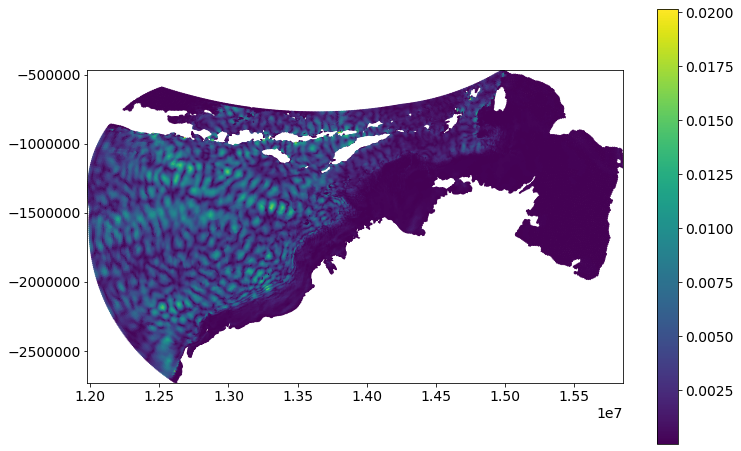

In [26]:
plt.figure(figsize=(12,8))
sun.plotcelldata(np.abs(Aa[4,...] + 1j*Ba[4,...]))

In [27]:
# Write the grid variables
def write_nc_var(nc, var, name, dimensions, attdict, dtype='f8'):
    tmp=nc.createVariable(name, dtype, dimensions)
    for aa in list(attdict.keys()):
        tmp.setncattr(aa,attdict[aa])
    nc.variables[name][:] = var

def writeNC(sun, outfile):
    """
    Export the grid variables to a netcdf file
    """
    self = sun
    Nkmax = self.Nk.max()
    maxfaces = self.nfaces.max()

    nc = Dataset(outfile, 'w', format='NETCDF4_CLASSIC')
    nc.Description = 'SUNTANS History file'
    nc.Author = ''
    nc.Created = datetime.now().isoformat()

    nc.createDimension('Nc', self.Nc)
    nc.createDimension('Np', self.Np)
    if hasattr(self, 'Ne'):
        nc.createDimension( self.Ne)
    else:
        print('No dimension: Ne')

    nc.createDimension('Nk', Nkmax)
    nc.createDimension('Nkw', Nkmax+1)
    nc.createDimension('numsides', maxfaces)
    nc.createDimension('two', 2)
    nc.createDimension('time', 0) # Unlimited

    # Just write the bare-bones grid variables (everything else can be calculated)
    gridvars = ['cells','xp','yp','xv','yv','nfaces']

    for vv in gridvars:
        if vv in self.__dict__ and vv != 'time':
            if self.VERBOSE:
                print('Writing variables: %s'%vv)
            write_nc_var(nc, self[vv],vv,ugrid[vv]['dimensions'],ugrid[vv]['attributes'],dtype=ugrid[vv]['dtype'])


    nc.close()


In [28]:
outfile = '../SCENARIOS/OUTPUT_NWS_2km_GLORYS_hex_2013_2014/NWS_2km_GLORYS_hex_2013_2014_SSHBC_Harmonics.nc'

In [29]:
# Write the output to disk
writeNC(sun, outfile)

No dimension: Ne


In [30]:
nc = Dataset(outfile,'a')

nc.Title = 'SUNTANS non-stationary harmonic output'
nc.Constituent_Names = ' '.join(names)
nc.Number_Annual_Harmonics = na
mytime = datetime.strftime(reftime,'%Y-%m-%d %H:%M:%S')
nc.ReferenceDate = mytime
#nc.SimulationTime = '%s - %s'%(datetime.strftime(self.time[self.tstep[0]],'%Y-%m-%d %H:%M:%S'),datetime.strftime(self.time[self.tstep[-1]],'%Y-%m-%d %H:%M:%S'))

Ntide = len(frq_all)
# Add another dimension
nc.createDimension('Ntide', Ntide)

write_nc_var(nc,frq_all, 'omega', ('Ntide',),\
        {'long_name':'frequency','units':'rad s-1'})


# Create the output variables
vv='SSH_BC'
units = 'm'
dims = ('Ntide','Nc')
coords = 'omega xv yv'

name = vv+'_var'
longname = '%s - signal variance'%vv
write_nc_var(nc, ssh_var, name, ('Nc',),\
    {'long_name':longname,'units':'m^2','coordinates':coords},\
        )


name = vv+'_aa'
longname = '%s - mean amplitude'%vv
write_nc_var(nc, aa, name, ('Nc',),\
    {'long_name':longname,'units':units,'coordinates':coords},\
        )

name = vv+'_Aa'
longname = '%s - real complex amplitude'%vv
write_nc_var(nc, Aa, name, dims,\
    {'long_name':longname,'units':units,'coordinates':coords},\
        )

name = vv+'_Ba'
longname = '%s - imaginary complex amplitude'%vv
write_nc_var(nc, Ba, name, dims,\
    {'long_name':longname,'units':units,'coordinates':coords},\
        )

nc.close()


In [31]:
# Test opening the file
ds = xr.open_dataset(outfile)
ds

<xarray.Dataset>
Dimensions:     (Nc: 225368, Np: 454016, Ntide: 35, numsides: 8)
Coordinates:
    xv          (Nc) float64 ...
    yv          (Nc) float64 ...
    omega       (Ntide) float64 ...
Dimensions without coordinates: Nc, Np, Ntide, numsides
Data variables:
    cells       (Nc, numsides) int32 ...
    xp          (Np) float64 ...
    yp          (Np) float64 ...
    nfaces      (Nc) int32 ...
    SSH_BC_var  (Nc) float64 ...
    SSH_BC_aa   (Nc) float64 ...
    SSH_BC_Aa   (Ntide, Nc) float64 ...
    SSH_BC_Ba   (Ntide, Nc) float64 ...
Attributes:
    Description:              SUNTANS History file
    Author:                   
    Created:                  2020-07-09T16:11:13.143664
    Title:                    SUNTANS non-stationary harmonic output
    Constituent_Names:        M2 S2 N2 K1 O1
    Number_Annual_Harmonics:  3
    ReferenceDate:            1990-01-01 00:00:00

In [32]:
sun2 = Sunxray(outfile)

/home/mrayson/code/soda/soda/dataio/suntans/sunxray.py:53: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  mask_and_scale=True, decode_times=True)
/home/mrayson/group/mrayson/miniconda3/envs/soda/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the data

In [33]:
sun2

<xarray.Dataset>
Dimensions:     (Nc: 225368, Np: 454016, Ntide: 35, numsides: 8)
Coordinates:
    omega       (Ntide) float64 0.0001399 0.0001401 ... 6.8e-05 6.82e-05
    yv          (Nc) float64 -2.188e+06 -2.2e+06 ... -1.463e+06 -1.458e+06
    xv          (Nc) float64 1.213e+07 1.214e+07 ... 1.31e+07 1.312e+07
Dimensions without coordinates: Nc, Np, Ntide, numsides
Data variables:
    xp          (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    SSH_BC_Ba   (Ntide, Nc) float64 dask.array<chunksize=(35, 225368), meta=np.ndarray>
    cells       (Nc, numsides) int32 dask.array<chunksize=(225368, 8), meta=np.ndarray>
    yp          (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    SSH_BC_aa   (Nc) float64 dask.array<chunksize=(225368,), meta=np.ndarray>
    nfaces      (Nc) int32 dask.array<chunksize=(225368,), meta=np.ndarray>
    SSH_BC_var  (Nc) float64 dask.array<chunksize=(225368,), meta=np.ndarray>
    SSH_BC_Aa   (Ntide, Nc) float64 dask.array<ch

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x2b875ea9da50>)

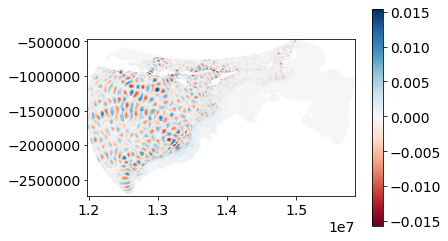

In [34]:
plt.figure()
sun2.plotcelldata(sun2._ds.SSH_BC_Aa[4,...], cmap='RdBu')

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x2b875ed44290>)

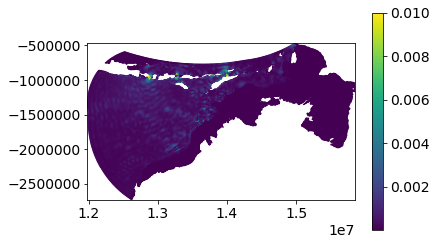

In [35]:
plt.figure()
sun2.plotcelldata(sun2._ds.SSH_BC_var, vmax=0.01)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x2b876b806c90>)

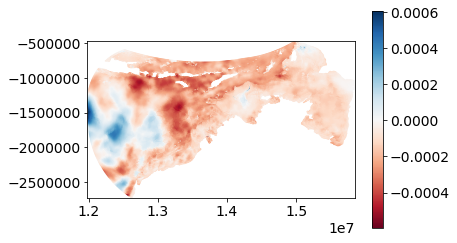

In [37]:
plt.figure()
sun2.plotcelldata(sun2._ds.SSH_BC_aa, cmap='RdBu')

In [42]:
sun2.interpolate(sun2._ds.SSH_BC_Aa[1,...], 1.3e7,-2e6)

masked_array(data=0.00024587,
             mask=False,
       fill_value=1e+20)